In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzvf -

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CNN3D11(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN3D11, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
        self.batch_norm1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
        self.batch_norm_fc = nn.BatchNorm1d(12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return x


In [ ]:
from torchsummary import summary

In [ ]:
model = CNN3D11()
summary(model, (1, 182, 182, 218), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
       BatchNorm3d-2       [-1, 32, 37, 37, 44]              64
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
       BatchNorm3d-5       [-1, 16, 18, 18, 22]              32
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
       BatchNorm3d-8          [-1, 8, 9, 9, 11]              16
         MaxPool3d-9           [-1, 8, 4, 4, 5]               0
          Flatten-10                  [-1, 640]               0
           Linear-11                   [-1, 12]           7,692
      BatchNorm1d-12                   [-1, 12]              24
           Linear-13                    [-1, 3]              39
Total params: 29,203
Trainable params: 

In [ ]:
model = None
del model

## dataset creation

In [ ]:
import pandas as pd

tuning_df = pd.read_csv('ADNI3_tune.csv').drop('Unnamed: 0', axis=1)
testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
## if two classes:
tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)

train_df = tuning_df[tuning_df['Subject'].isin(train_subjects)][['Image Data ID','Group','Subject']]
train_images, train_labels, train_subjects = train_df.T.to_numpy()

valid_df = tuning_df[tuning_df['Subject'].isin(valid_subjects)][['Image Data ID','Group','Subject']]
valid_images, valid_labels, valid_subjects = valid_df.T.to_numpy()


In [ ]:
import re

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [ ]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

train_set = list(zip(train_images, train_labels))

train_set = list(filter(image_exists, train_set))

train_images, train_labels = zip(*train_set)

In [ ]:
train_image_paths = [id_to_path[k] for k in train_images]

In [ ]:
valid_set = list(zip(valid_images, valid_labels))

valid_set = list(filter(image_exists, valid_set))

valid_images, valid_labels = zip(*valid_set)

In [ ]:
valid_image_paths = [id_to_path[k] for k in valid_images]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)


y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CNNDataset(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CNNDataset(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 32
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
n_classes

2

In [ ]:
len(train_loader)

34

In [ ]:
len(valid_loader)

4

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints3/part2' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = '2c_baseline_cnn11_adni3.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = CNN3D11(num_classes=2)
model.to(device)

# Number of training epochs
num_epochs = 30

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=1.0, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break




Epoch 0:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6845
Training Accuracy: 57.85%
Training F1-Score: 65.76%
          AD        CN
AD  0.432203  0.567797
CN  0.403545  0.596455


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7158
Validation Accuracy: 28.33%
Validation F1-Score: 29.13%
          AD        CN
AD  0.842105  0.157895
CN  0.821782  0.178218
Epoch 0: SGD lr 0.000010 -> 0.000010
Epoch 0: saving...
Epoch 1:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6707
Training Accuracy: 62.67%
Training F1-Score: 69.64%
          AD        CN
AD  0.533898  0.466102
CN  0.361835  0.638165


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7670
Validation Accuracy: 43.33%
Validation F1-Score: 48.35%
          AD        CN
AD  0.842105  0.157895
CN  0.643564  0.356436
Epoch 1: SGD lr 0.000010 -> 0.000010
Epoch 1: saving...
Epoch 2:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6598
Training Accuracy: 64.90%
Training F1-Score: 71.42%
          AD        CN
AD  0.576271  0.423729
CN  0.342023  0.657977


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6471
Validation Accuracy: 71.67%
Validation F1-Score: 74.83%
          AD        CN
AD  0.578947  0.421053
CN  0.257426  0.742574
Epoch 2: SGD lr 0.000010 -> 0.000010
Epoch 2: saving...
Epoch 3:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6536
Training Accuracy: 66.48%
Training F1-Score: 72.70%
          AD        CN
AD  0.644068  0.355932
CN  0.332638  0.667362


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6397
Validation Accuracy: 71.67%
Validation F1-Score: 74.65%
          AD        CN
AD  0.526316  0.473684
CN  0.247525  0.752475
Epoch 3: SGD lr 0.000010 -> 0.000010
Epoch 3: saving...
Epoch 4:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6466
Training Accuracy: 68.90%
Training F1-Score: 74.61%
          AD        CN
AD  0.686441  0.313559
CN  0.310740  0.689260


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6538
Validation Accuracy: 69.17%
Validation F1-Score: 73.00%
          AD        CN
AD  0.631579  0.368421
CN  0.297030  0.702970
Epoch 4: SGD lr 0.000010 -> 0.000010
Epoch 4: saving...
Epoch 5:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6415
Training Accuracy: 69.82%
Training F1-Score: 75.32%
          AD        CN
AD  0.677966  0.322034
CN  0.299270  0.700730


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6362
Validation Accuracy: 73.33%
Validation F1-Score: 75.93%
          AD        CN
AD  0.526316  0.473684
CN  0.227723  0.772277
Epoch 5: SGD lr 0.000010 -> 0.000010
Epoch 5: saving...
Epoch 6:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6326
Training Accuracy: 72.24%
Training F1-Score: 77.26%
          AD        CN
AD  0.754237  0.245763
CN  0.281543  0.718457


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6332
Validation Accuracy: 73.33%
Validation F1-Score: 75.93%
          AD        CN
AD  0.526316  0.473684
CN  0.227723  0.772277
Epoch 6: SGD lr 0.000010 -> 0.000010
Epoch 6: saving...
Epoch 7:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6279
Training Accuracy: 72.24%
Training F1-Score: 77.26%
          AD        CN
AD  0.754237  0.245763
CN  0.281543  0.718457


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6291
Validation Accuracy: 71.67%
Validation F1-Score: 74.43%
          AD        CN
AD  0.473684  0.526316
CN  0.237624  0.762376
Epoch 7: SGD lr 0.000010 -> 0.000010
Epoch 7: saving...
Epoch 8:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6216
Training Accuracy: 73.17%
Training F1-Score: 78.01%
          AD        CN
AD  0.788136  0.211864
CN  0.275287  0.724713


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6385
Validation Accuracy: 71.67%
Validation F1-Score: 74.65%
          AD        CN
AD  0.526316  0.473684
CN  0.247525  0.752475
Epoch 8: SGD lr 0.000010 -> 0.000010
Epoch 8: saving...
Epoch 9:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6147
Training Accuracy: 74.56%
Training F1-Score: 79.08%
          AD        CN
AD  0.796610  0.203390
CN  0.260688  0.739312


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6288
Validation Accuracy: 71.67%
Validation F1-Score: 74.43%
          AD        CN
AD  0.473684  0.526316
CN  0.237624  0.762376
Epoch 9: SGD lr 0.000010 -> 0.000010
Epoch 9: saving...
Epoch 10:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6122
Training Accuracy: 74.74%
Training F1-Score: 79.24%
          AD        CN
AD  0.805085  0.194915
CN  0.259645  0.740355


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6380
Validation Accuracy: 71.67%
Validation F1-Score: 74.65%
          AD        CN
AD  0.526316  0.473684
CN  0.247525  0.752475
Epoch 10: SGD lr 0.000010 -> 0.000010
Epoch 10: saving...
Epoch 11:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6020
Training Accuracy: 76.23%
Training F1-Score: 80.44%
          AD        CN
AD  0.855932  0.144068
CN  0.249218  0.750782


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6051
Validation Accuracy: 73.33%
Validation F1-Score: 75.42%
          AD        CN
AD  0.421053  0.578947
CN  0.207921  0.792079
Epoch 11: SGD lr 0.000010 -> 0.000010
Epoch 11: saving...
Epoch 12:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5968
Training Accuracy: 77.16%
Training F1-Score: 81.14%
          AD        CN
AD  0.855932  0.144068
CN  0.238790  0.761210


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6241
Validation Accuracy: 70.00%
Validation F1-Score: 73.15%
          AD        CN
AD  0.473684  0.526316
CN  0.257426  0.742574
Epoch 12: SGD lr 0.000010 -> 0.000010
Epoch 12: saving...
Epoch 13:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5916
Training Accuracy: 77.72%
Training F1-Score: 81.57%
          AD        CN
AD  0.855932  0.144068
CN  0.232534  0.767466


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6378
Validation Accuracy: 68.33%
Validation F1-Score: 72.05%
          AD        CN
AD  0.526316  0.473684
CN  0.287129  0.712871
Epoch 13: SGD lr 0.000010 -> 0.000010
Epoch 13: saving...
Epoch 14:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5849
Training Accuracy: 79.20%
Training F1-Score: 82.68%
          AD        CN
AD  0.847458  0.152542
CN  0.214807  0.785193


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6348
Validation Accuracy: 69.17%
Validation F1-Score: 72.70%
          AD        CN
AD  0.526316  0.473684
CN  0.277228  0.722772
Epoch 14: SGD lr 0.000010 -> 0.000010
Epoch 14: saving...
Epoch 15:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5814
Training Accuracy: 79.29%
Training F1-Score: 82.81%
          AD        CN
AD  0.881356  0.118644
CN  0.217935  0.782065


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6140
Validation Accuracy: 70.83%
Validation F1-Score: 73.79%
          AD        CN
AD  0.473684  0.526316
CN  0.247525  0.752475
Epoch 15: SGD lr 0.000010 -> 0.000010
Epoch 15: saving...
Epoch 16:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5805
Training Accuracy: 79.20%
Training F1-Score: 82.68%
          AD        CN
AD  0.847458  0.152542
CN  0.214807  0.785193


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6181
Validation Accuracy: 70.00%
Validation F1-Score: 73.15%
          AD        CN
AD  0.473684  0.526316
CN  0.257426  0.742574
Epoch 16: SGD lr 0.000010 -> 0.000010
Epoch 16: saving...
Epoch 17:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5729
Training Accuracy: 80.41%
Training F1-Score: 83.61%
          AD        CN
AD  0.855932  0.144068
CN  0.202294  0.797706


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6001
Validation Accuracy: 75.00%
Validation F1-Score: 76.95%
          AD        CN
AD  0.473684  0.526316
CN  0.198020  0.801980
Epoch 17: SGD lr 0.000010 -> 0.000010
Epoch 17: saving...
Epoch 18:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5659
Training Accuracy: 81.24%
Training F1-Score: 84.27%
          AD        CN
AD  0.872881  0.127119
CN  0.194995  0.805005


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6008
Validation Accuracy: 73.33%
Validation F1-Score: 75.69%
          AD        CN
AD  0.473684  0.526316
CN  0.217822  0.782178
Epoch 18: SGD lr 0.000010 -> 0.000010
Epoch 18: saving...
Epoch 19:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5631
Training Accuracy: 82.45%
Training F1-Score: 85.22%
          AD        CN
AD  0.889831  0.110169
CN  0.183525  0.816475


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6058
Validation Accuracy: 71.67%
Validation F1-Score: 74.43%
          AD        CN
AD  0.473684  0.526316
CN  0.237624  0.762376
Epoch 19: SGD lr 0.000010 -> 0.000010
Epoch 19: saving...
Epoch 20:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5570
Training Accuracy: 84.96%
Training F1-Score: 87.17%
          AD        CN
AD  0.906780  0.093220
CN  0.157456  0.842544


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6080
Validation Accuracy: 72.50%
Validation F1-Score: 75.29%
          AD        CN
AD  0.526316  0.473684
CN  0.237624  0.762376
Epoch 20: SGD lr 0.000010 -> 0.000010
Epoch 20: saving...
Epoch 21:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5520
Training Accuracy: 83.38%
Training F1-Score: 85.94%
          AD        CN
AD  0.898305  0.101695
CN  0.174140  0.825860


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6031
Validation Accuracy: 73.33%
Validation F1-Score: 75.93%
          AD        CN
AD  0.526316  0.473684
CN  0.227723  0.772277
Epoch 21: SGD lr 0.000010 -> 0.000010
Epoch 21: saving...
Epoch 22:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5474
Training Accuracy: 84.59%
Training F1-Score: 86.88%
          AD        CN
AD  0.906780  0.093220
CN  0.161627  0.838373


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6016
Validation Accuracy: 73.33%
Validation F1-Score: 75.69%
          AD        CN
AD  0.473684  0.526316
CN  0.217822  0.782178
Epoch 22: SGD lr 0.000010 -> 0.000010
Epoch 22: saving...
Epoch 23:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5423
Training Accuracy: 85.52%
Training F1-Score: 87.56%
          AD        CN
AD  0.889831  0.110169
CN  0.149114  0.850886


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5900
Validation Accuracy: 74.17%
Validation F1-Score: 76.32%
          AD        CN
AD  0.473684  0.526316
CN  0.207921  0.792079
Epoch 23: SGD lr 0.000010 -> 0.000010
Epoch 23: saving...
Epoch 24:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5371
Training Accuracy: 85.89%
Training F1-Score: 87.91%
          AD        CN
AD  0.923729  0.076271
CN  0.149114  0.850886


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6080
Validation Accuracy: 74.17%
Validation F1-Score: 76.79%
          AD        CN
AD  0.578947  0.421053
CN  0.227723  0.772277
Epoch 24: SGD lr 0.000010 -> 0.000010
Epoch 24: saving...
Epoch 25:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5321
Training Accuracy: 86.91%
Training F1-Score: 88.69%
          AD        CN
AD  0.915254  0.084746
CN  0.136601  0.863399


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5979
Validation Accuracy: 72.50%
Validation F1-Score: 75.29%
          AD        CN
AD  0.526316  0.473684
CN  0.237624  0.762376
Epoch 25: SGD lr 0.000010 -> 0.000010
Epoch 25: saving...
Epoch 26:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5317
Training Accuracy: 86.17%
Training F1-Score: 88.09%
         AD       CN
AD  0.90678  0.09322
CN  0.14390  0.85610


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5771
Validation Accuracy: 78.33%
Validation F1-Score: 79.77%
          AD        CN
AD  0.526316  0.473684
CN  0.168317  0.831683
Epoch 26: SGD lr 0.000010 -> 0.000010
Epoch 26: saving...
Epoch 27:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5252
Training Accuracy: 87.47%
Training F1-Score: 89.10%
          AD        CN
AD  0.906780  0.093220
CN  0.129301  0.870699


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6028
Validation Accuracy: 73.33%
Validation F1-Score: 76.14%
          AD        CN
AD  0.578947  0.421053
CN  0.237624  0.762376
Epoch 27: SGD lr 0.000010 -> 0.000010
Epoch 27: saving...
Epoch 28:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5250
Training Accuracy: 88.02%
Training F1-Score: 89.60%
          AD        CN
AD  0.940678  0.059322
CN  0.127216  0.872784


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5851
Validation Accuracy: 75.00%
Validation F1-Score: 77.21%
          AD        CN
AD  0.526316  0.473684
CN  0.207921  0.792079
Epoch 28: SGD lr 0.000010 -> 0.000010
Epoch 28: saving...
Epoch 29:


  0%|          | 0/34 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5200
Training Accuracy: 88.86%
Training F1-Score: 90.23%
          AD        CN
AD  0.923729  0.076271
CN  0.115746  0.884254


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5771
Validation Accuracy: 78.33%
Validation F1-Score: 79.77%
          AD        CN
AD  0.526316  0.473684
CN  0.168317  0.831683
Epoch 29: SGD lr 0.000010 -> 0.000010
Epoch 29: saving...


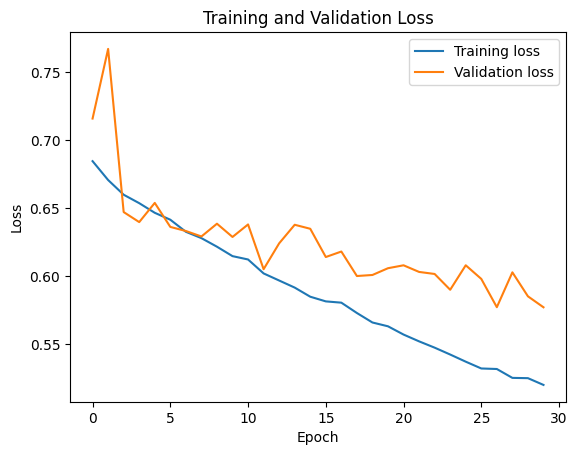

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()